# Random forests
## Lecture objectives

1. Explain how and why to do a train-test split
2. Demonstrate how to estimate and interpret a random forests model

We'll continue with our example of ADUs in Los Angeles.

First, let's load in the pandas DataFrame that we saved at the end of the previous video lecture.

In [1]:
import pandas as pd
joinedDf = pd.read_pickle('../scratch/joined_permits.pandas')

# check it looks OK
joinedDf.head()

,UseType,UseDescription,YearBuilt1,Units1,Bedrooms1,Bathrooms1,SQFTmain1,Roll_LandValue,Roll_ImpValue,Roll_LandBaseYear,Roll_ImpBaseYear,CENTER_LAT,CENTER_LON,Assessor Book,Assessor Page,Assessor Parcel,# of Accessory Dwelling Units,hasADU
APN,,,,,,,,,,,,,,,,,,
2004-001-003,Residential,Single,1973.0,1.0,4.0,3.0,2090.0,684054.0,289482.0,2006,2006,34.220220,-118.620669,NaN,NaN,NaN,NaN,False
2004-001-004,Residential,Single,1973.0,1.0,5.0,3.0,2479.0,356150.0,245944.0,2010,2010,34.220039,-118.620668,NaN,NaN,NaN,NaN,False
2004-001-005,Residential,Single,1973.0,1.0,4.0,2.0,2057.0,505922.0,190867.0,2018,2018,34.219858,-118.620676,NaN,NaN,NaN,NaN,False
2004-001-008,Residential,Single,1978.0,1.0,4.0,3.0,2423.0,123435.0,213347.0,1980,1980,34.220334,-118.622706,NaN,NaN,NaN,NaN,False
2004-001-009,Residential,Single,1978.0,1.0,4.0,3.0,2226.0,134500.0,201858.0,1984,1984,34.220323,-118.623050,NaN,NaN,NaN,NaN,False


## Train-test split
In almost any prediction problem, we want to split the data into a "training sample" and a "testing sample". Assuming you have a large enough sample, this helps to evaluate the performance of your machine learning model. Essentially, you are assessing how well the model performs against new data that it has not seen before.

`scikit-learn` has built in functions to split the data. Note that this chooses a random sample. If you want to replicate your analysis, the `random_state` argument can do that. This works the same as a "seed" in other statistical software. It doesn't matter which seed (or random state) you choose, as long as it's the same each time.

In [2]:
from sklearn.model_selection import train_test_split
train_test_split?

Signature:
train_test_split(
    *arrays,
    test_size=None,
    train_size=None,
    random_state=None,
    shuffle=True,
    stratify=None,
)
Docstring:
Split arrays or matrices into random train and test subsets.

Quick utility that wraps input validation,
``next(ShuffleSplit().split(X, y))``, and application to input data
into a single call for splitting (and optionally subsampling) data into a
one-liner.

Read more in the :ref:`User Guide <cross_validation>`.

Parameters
----------
*arrays : sequence of indexables with same length / shape[0]
    Allowed inputs are lists, numpy arrays, scipy-sparse
    matrices or pandas dataframes.

test_size : float or int, default=None
    If float, should be between 0.0 and 1.0 and represent the proportion
    of the dataset to include in the test split. If int, represents the
    absolute number of test samples. If None, the value is set to the
    complement of the train size. If ``train_size`` is also None, it will
    be set to 0.25.

trai

At this point, we also need to choose our variables. Our `y` variable is whether there is an ADU or not: `hasADU`.

For our `x` (predictor) variables, let's start with a few: `['SQFTmain1', 'Roll_LandValue', 'Roll_ImpValue']`.

We also need to drop Null values. Some `pandas` and `numpy` functions do this automatically, but the `scikit-learn` functions normally require us to drop the Null values ourselves.

In [5]:
xvars = ['SQFTmain1', 'Roll_LandValue', 'Roll_ImpValue']
yvar = 'hasADU'

# create a dataframe with no NaNs
df_to_fit = joinedDf[xvars+[yvar]].dropna()

X_train, X_test, y_train, y_test = train_test_split(
    df_to_fit[xvars], df_to_fit[yvar], test_size = 0.25, random_state = 1)

# check we have a reasonable split
print(len(X_train), len(y_train) )
print(len(X_test), len(y_test) )

583113 583113
194372 194372


If you rerun the above block of code, you should get exactly the same sample.

But if you change `random_state` (or omit that argument), you'll get a different random sample.

In [6]:
X_train.head()

,SQFTmain1,Roll_LandValue,Roll_ImpValue
APN,,,
6342-030-027,702.0,247573.0,187357.0
6018-010-023,1298.0,449449.0,112355.0
6070-015-016,804.0,80032.0,59850.0
4326-030-028,2460.0,156256.0,97365.0
4119-038-091,710.0,144908.0,74327.0


## Random Forests
Now we are ready to do some machine learning!

Random forests are based on the idea of a decision tree. At the crudest level, imagine a classifier that predicts `hasADU=True` if the lot is residential and larger than 5,000sf, and `hasADU=False` otherwise. (The exact threshold such as 5,000sf is estimated from the data.)

Here's the example from the Reades et al. article about urban gentrification.

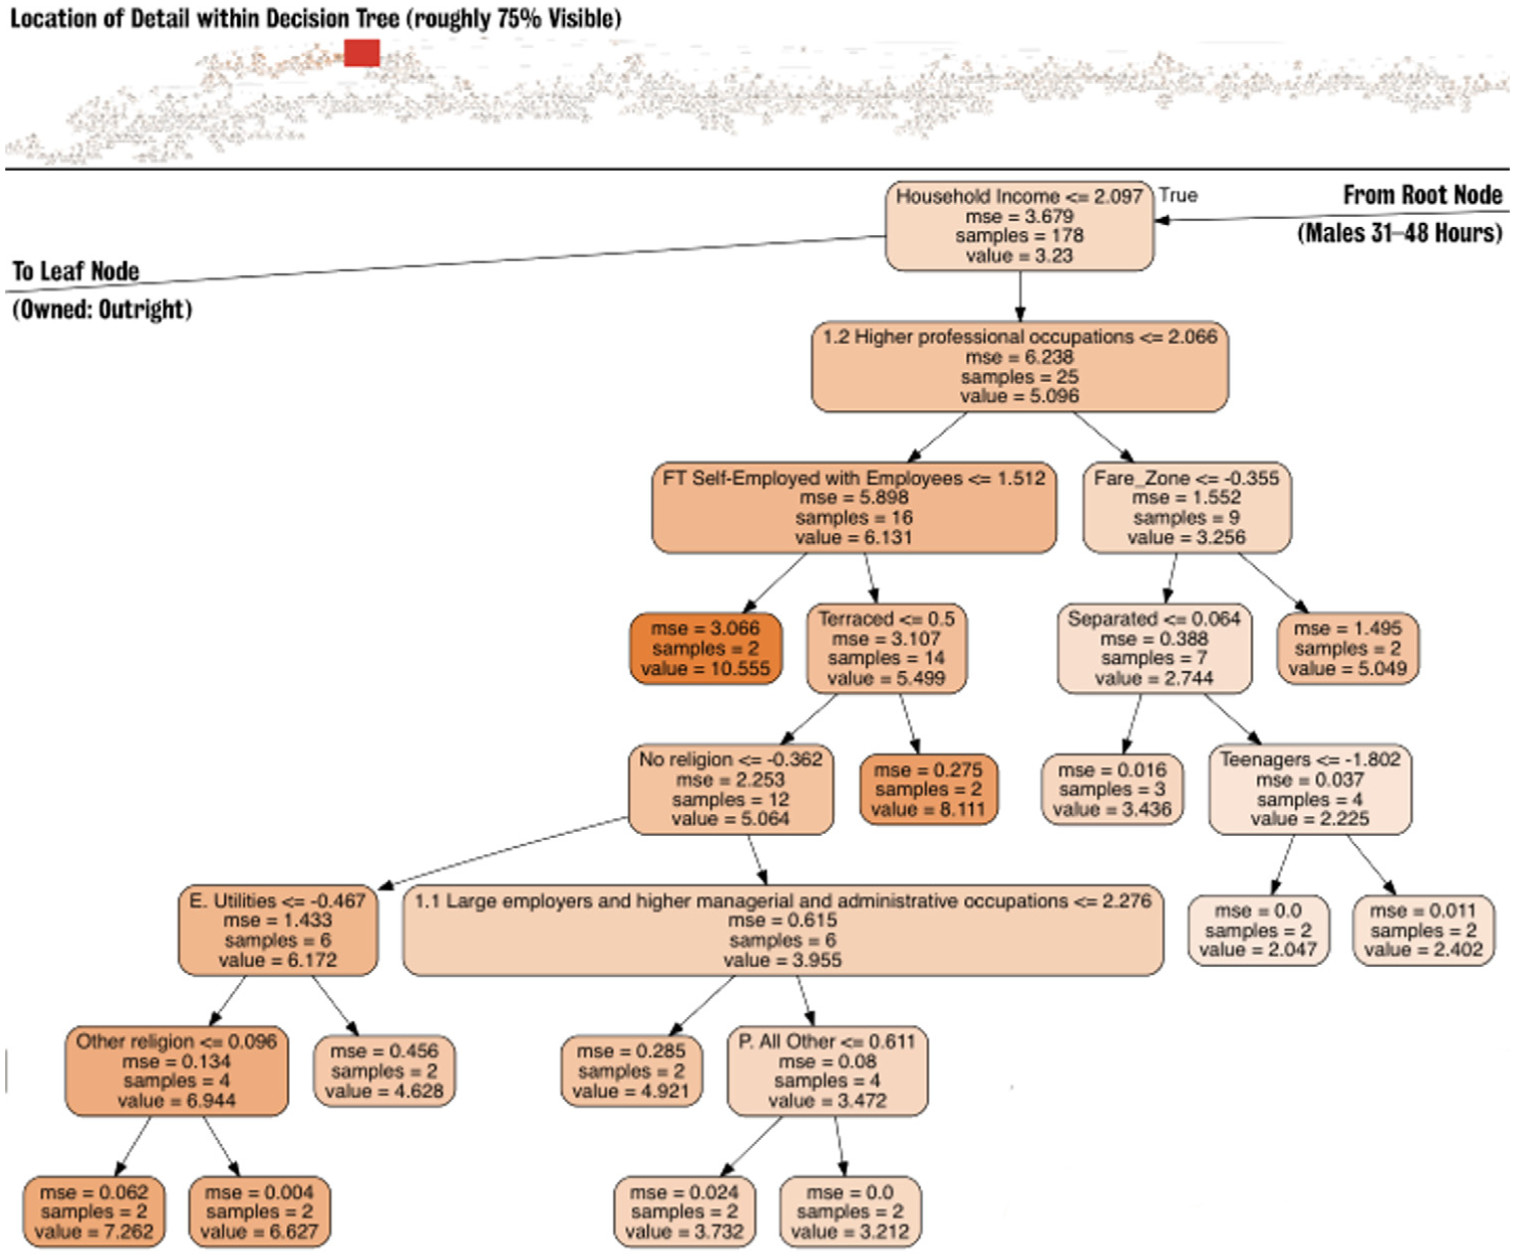

Such a deterministic tree is unlikely to do a great job in prediction. Enter random forests, which are a collection of decision trees. Each tree is trained on a subsample of the data. Then the predictions are combined, rather like the "wisdom of crowds." Formally, this process is called *ensemble learning*.

[For a more in-depth explanation, see this article by Neil Liberman.](https://towardsdatascience.com/decision-trees-and-random-forests-df0c3123f991)

Random forests are implemented in `scikit-learn`. An important parameter is the `n_estimators` (i.e., the number of trees). Up to a point, more trees will mean better predictions. But more trees also mean that the code will run more slowly. A general rule: get it working with a small number of trees.

Even with 50 trees, you might hear your computer fan run a bit faster.

In [7]:
from sklearn.ensemble import RandomForestClassifier # note there is also a RandomForestRegressor

# initialize the random forest classifer object
rf = RandomForestClassifier(n_estimators = 50, random_state = 1)

# now fit the model
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=50, random_state=1)

Once we've estimated the model on the *training* dataset, we can apply it to predict whether an ADU will be built on an "unseen" parcel. In other words, we apply the predictions to the *test* dataset.

That gives us an array of predictions.

In [8]:
y_pred = rf.predict(X_test)
y_pred

array([False, False, False, ..., False, False, False])

Let's verify that we have one prediction for each row of the data frame.

In [9]:
print(len(X_test), len(y_pred))

194372 194372


How can we assess the performance of this model? One quick check is to look at the means (i.e., the percentage `True`) in each sample.

In [10]:
print('Predicted fraction True: {:.4f}. Actual fraction True: {:.4f}'.format(
    y_pred.mean(), y_test.mean()))

Predicted fraction True: 0.0006. Actual fraction True: 0.0319


So that doesn't look too good. In the next lecture, we'll look at more sophisticated ways to assess the predictive accuracy of a machine learning model.

But for now, let's see if our overall predictions can be improved by some extensions:
* Adding more variables
* Adding more trees
* Adjusting other hyperparameters (we won't discuss that here)

<div class="alert alert-block alert-info">
    <strong>Exercise:</strong> Look at the documentation for <strong>RandomForestClassifier</strong>. How would you increase the number of trees? What other "hyperparameters" might you experiment with?
</div>

Let's throw all the variables in our dataset into the model. This would be bad practice for a hypothesis-testing oriented statistical model. But with prediction, we can throw in the kitchen sink, and rely on the model to separate out what is useful.

Note that string variables need to be encoded into dummy variables before we can use them. For example, our `UseType` and `UseDescription` variables need to be split into a series of True or False variables such as `Residential`, `Commercial`, etc.

The [`get_dummies()` function](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html) is useful for this. It converts a string into a series of binary True or False (i.e., dummy) variables.

In [11]:
joinedDf.UseType.unique()

array(['Residential', 'Commercial', 'Recreational', 'Government',
       'Institutional', 'Industrial', 'Miscellaneous', None,
       'Irrigated Farm'], dtype=object)

In [12]:
joinedDf.UseDescription.unique()

array(['Single', 'Office Buildings',
       'Clubs., Lodge Halls, Fraternal Organizations', 'Stores',
       'Store Combination', 'Five or more apartments',
       'Restaurants, Cocktail Lounges', 'Two Units', 'Government Parcel',
       'Hospitals', 'Shopping Centers (Neighborhood, community)',
       'Department Stores', 'Professional Buildings',
       'Homes For Aged & Others', 'Schools (Private)', 'Churches',
       'Nurseries or Greenhouses', 'Service Stations',
       'Auto, Recreation EQPT, Construction EQPT, Sales & Service',
       'Parking Lots (Commercial Use Properties)',
       'Athletic & Amusement Facilities', 'Supermarkets',
       'Banks Savings & Loan', 'Four Units (Any Combination)',
       'Three Units (Any Combination)', 'Commercial',
       'Shopping Centers (Regional)', 'Rooming Houses', 'Bowling Alleys',
       'Mobile Homes', 'Hotel & Motels',
       'Lgt Manf.Sm. EQPT. Manuf Sm.Shps Instr.Manuf. Prnt Plnts',
       'Warehousing, Distribution, Storage',
      

In [14]:
dummies1 = pd.get_dummies(joinedDf.UseType, prefix='usetype_')  # creates a dataframe of dummies
dummies2 = pd.get_dummies(joinedDf.UseDescription, prefix='usedesc_')
print(joinedDf.UseType.head())
dummies1.head()

APN
2004-001-003    Residential
2004-001-004    Residential
2004-001-005    Residential
2004-001-008    Residential
2004-001-009    Residential
Name: UseType, dtype: object


,usetype__Commercial,usetype__Government,usetype__Industrial,usetype__Institutional,usetype__Irrigated Farm,usetype__Miscellaneous,usetype__Recreational,usetype__Residential
APN,,,,,,,,
2004-001-003,False,False,False,False,False,False,False,True
2004-001-004,False,False,False,False,False,False,False,True
2004-001-005,False,False,False,False,False,False,False,True
2004-001-008,False,False,False,False,False,False,False,True
2004-001-009,False,False,False,False,False,False,False,True


Notice that the index generated by `get_dummies()` is the same as our original data frame (it's the APN). So it's simple to join the dummies back to the original dataframe.

In [15]:
# join back to the original dataframe
joinedDf = joinedDf.join(dummies1).join(dummies2) 
joinedDf[['UseType']+dummies1.columns.tolist()].head()

,UseType,usetype__Commercial,usetype__Government,usetype__Industrial,usetype__Institutional,usetype__Irrigated Farm,usetype__Miscellaneous,usetype__Recreational,usetype__Residential
APN,,,,,,,,,
2004-001-003,Residential,False,False,False,False,False,False,False,True
2004-001-004,Residential,False,False,False,False,False,False,False,True
2004-001-005,Residential,False,False,False,False,False,False,False,True
2004-001-008,Residential,False,False,False,False,False,False,False,True
2004-001-009,Residential,False,False,False,False,False,False,False,True


Now, let's estimate a random forests classifier using these dummy variables, plus many other columns that might be useful predictors.

This is exactly the same code as above, just with an expanded set of X variables. 

In [16]:
xvars = (dummies1.columns.tolist() + dummies2.columns.tolist() + 
            ['YearBuilt1', 'Units1', 'Bedrooms1', 'Bathrooms1', 'SQFTmain1', 'Roll_LandValue', 
             'Roll_ImpValue', 'Roll_LandBaseYear', 'Roll_ImpBaseYear', 'CENTER_LAT', 'CENTER_LON' ])
yvar = 'hasADU'
df_to_fit = joinedDf[xvars+[yvar]].dropna()

X_train, X_test, y_train, y_test = train_test_split(
    df_to_fit[xvars], df_to_fit[yvar], test_size = 0.25, random_state = 1)

rf = RandomForestClassifier(n_estimators = 100, random_state = 1, n_jobs=-1) # n_jobs uses all your computer's cores

# now fit the model
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print('Predicted fraction True: {:.4f}. Actual fraction True: {:.4f}'.format(
    y_pred.mean(), y_test.mean()))

Predicted fraction True: 0.0013. Actual fraction True: 0.0319


So by this measure, our more complex model does slightly better. But it's still only predicting that 0.1% of parcels will have an ADU, compared to the real fraction of 3%.

Again, in the next lecture, we'll look at better ways to assess predictive performance. But these raw fractions are a useful start.

### Unpacking the decision trees
Finally, let's take a closer look at the decision trees. Remember, the random forests approach works by estimating an ensemble of trees, and then combining them to get the aggregate prediction.

Note that the previous model we estimated is too complex to plot, so let's make it simpler using the `max_depth` hyperparameter. That limits the number of levels of each decision tree.

How do we read this tree?
* The first line of each box is the decision criterion
* *Samples* gives the number of observations at each node on the tree
* *Values* gives the outcome (*y*) values, i.e. the number of parcels with and without an ADU

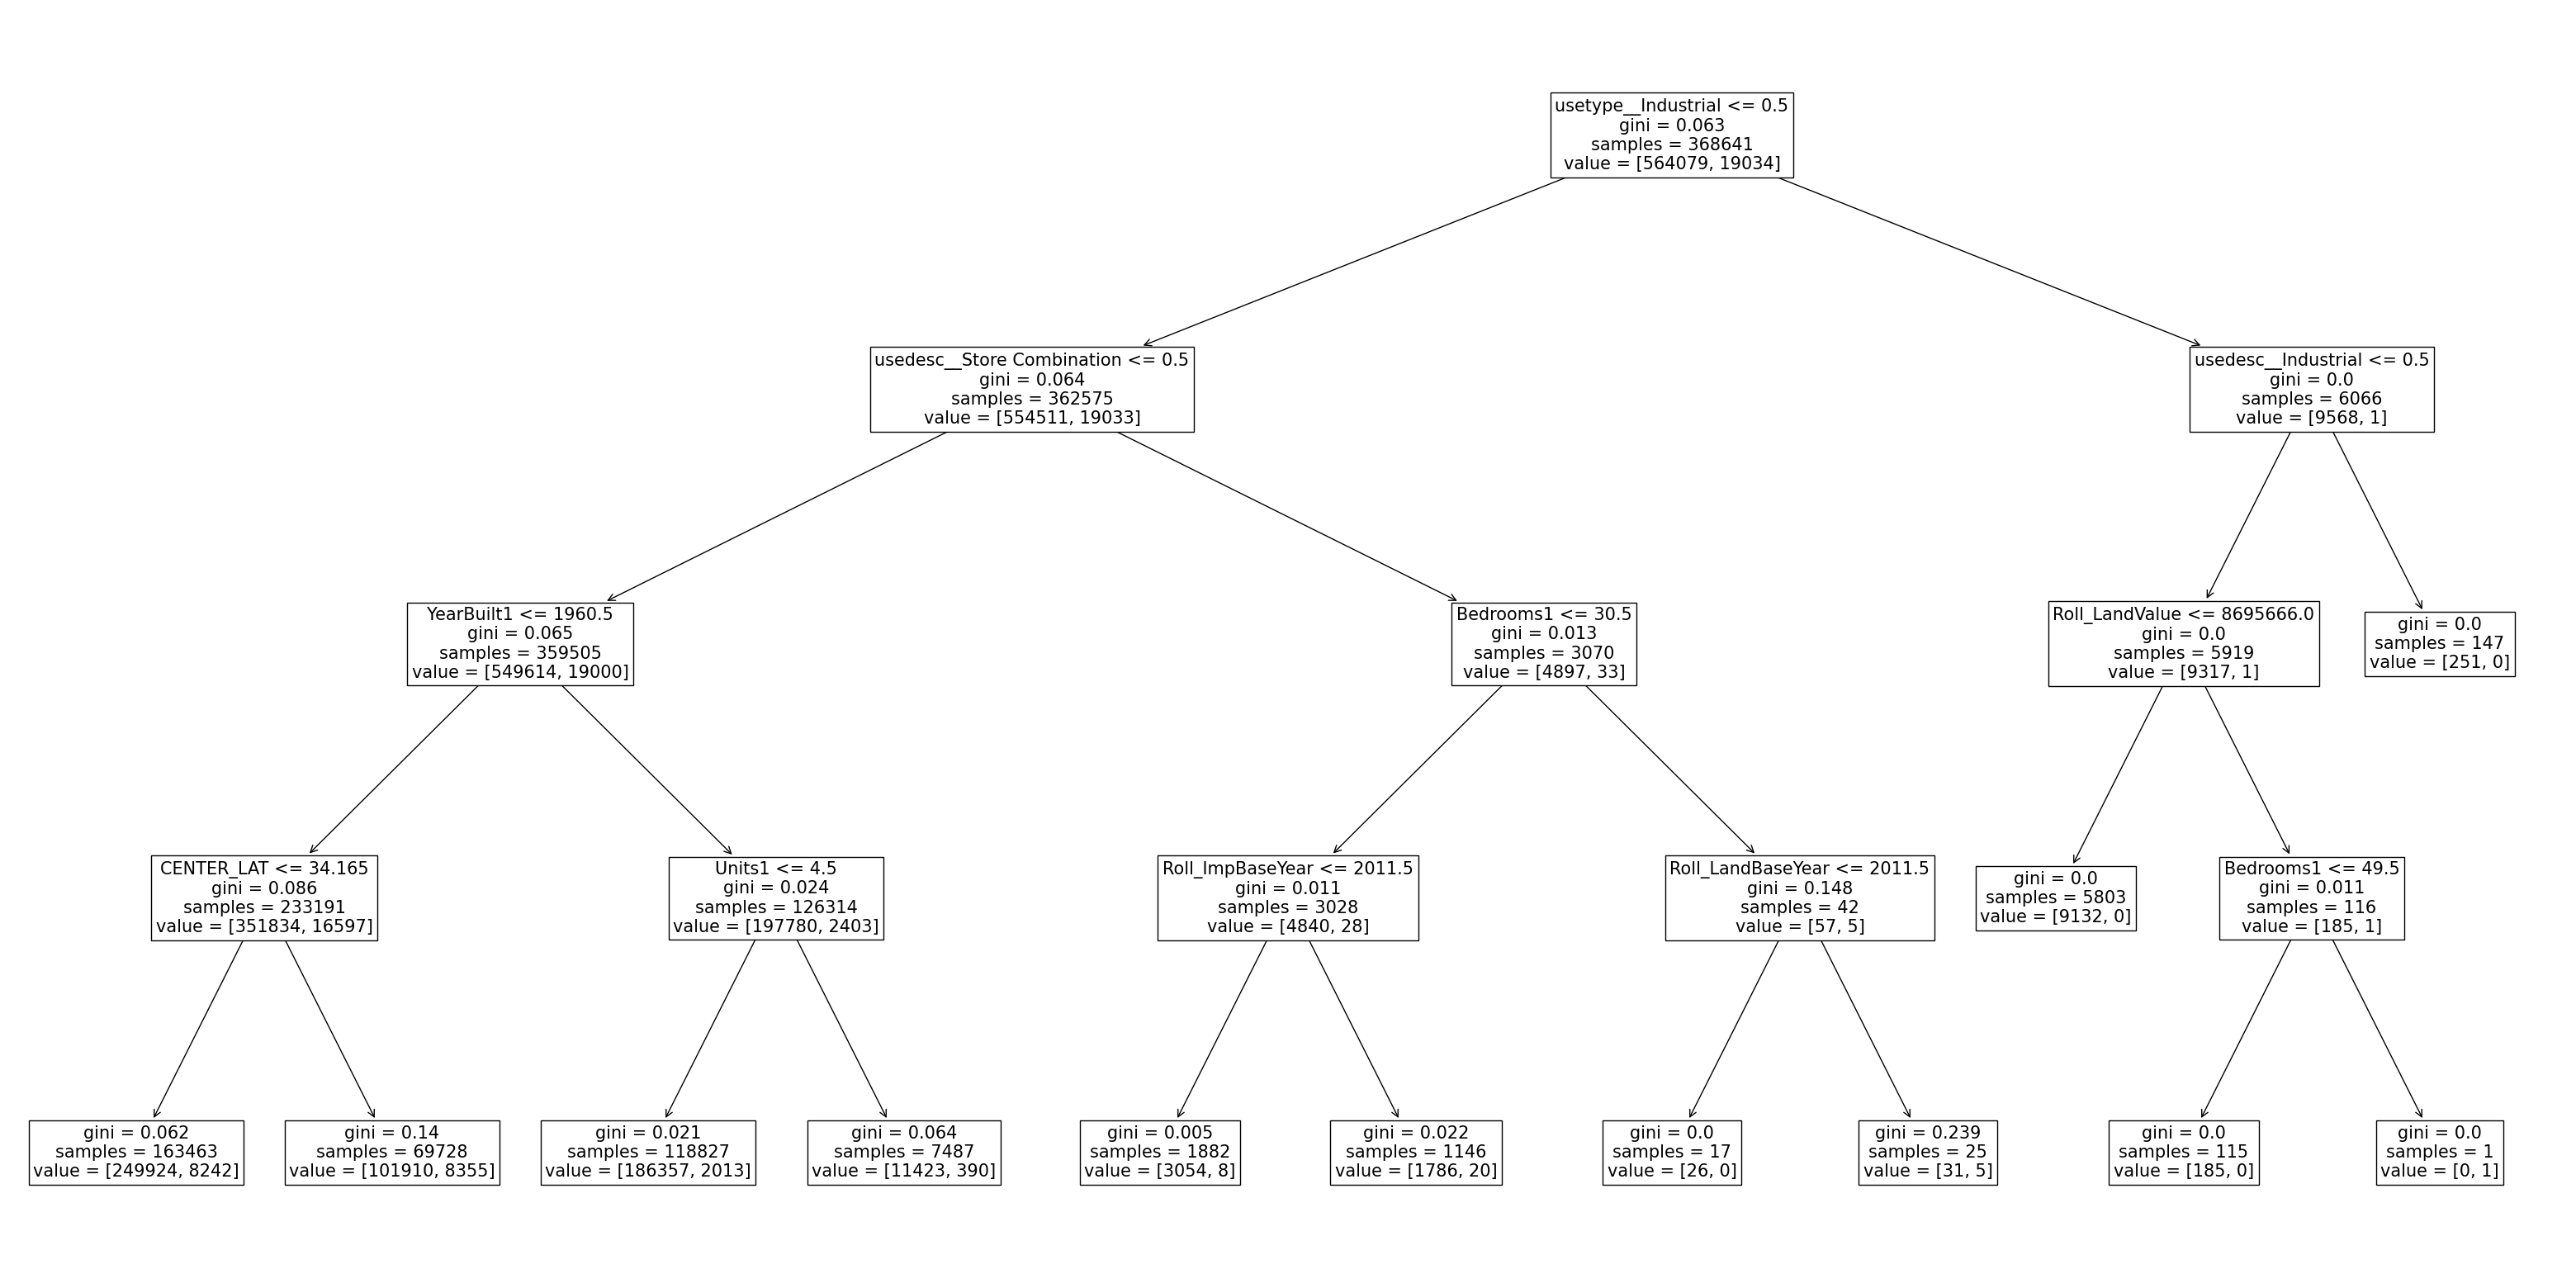

In [17]:
# same as before, but with max_depth=4
rf = RandomForestClassifier(n_estimators = 100, random_state = 1, n_jobs=-1, max_depth=4) 
rf.fit(X_train, y_train)

# now we have 100 estimators (trees), so let's pick the first one to visualize
e = rf.estimators_[0]

from sklearn import tree
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(40,20))  
_ = tree.plot_tree(e, feature_names = X_train.columns, fontsize=15, ax = ax)

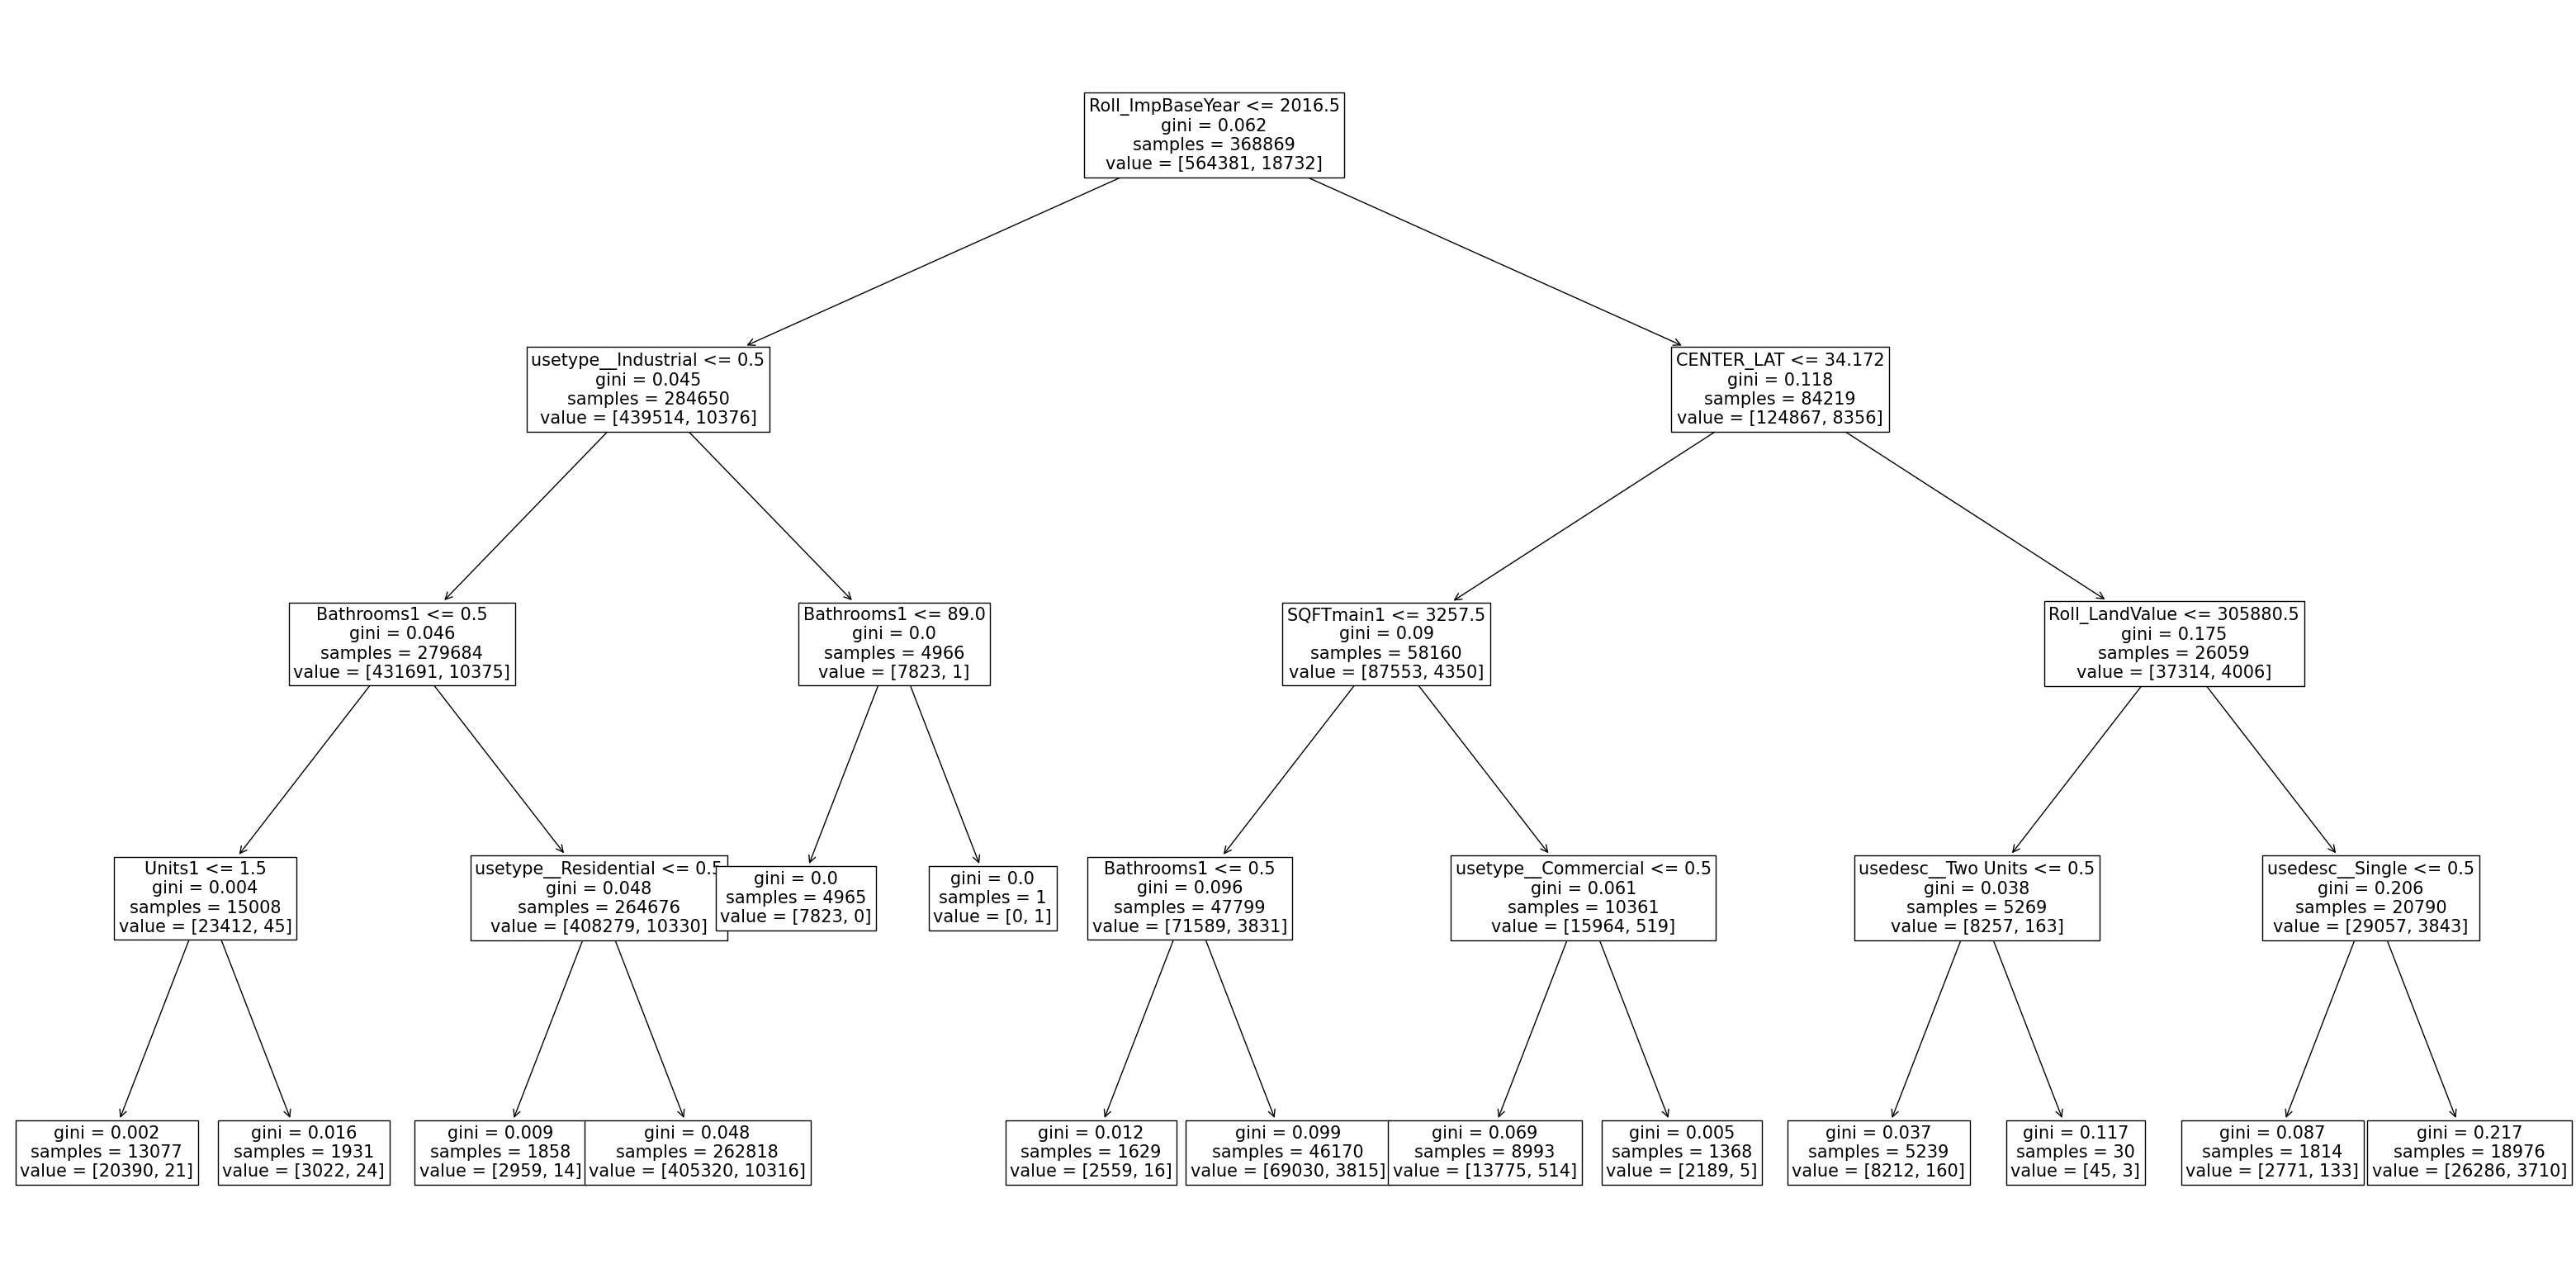

In [18]:
e = rf.estimators_[1]

fig, ax = plt.subplots(figsize=(40,20))  
_ = tree.plot_tree(e, feature_names = X_train.columns, fontsize=15, ax = ax)

We asked Python to generate 100 of these different trees. While each is deterministic, the power of the random forests is through *combining* the probabilities - ensemble learning.

<div class="alert alert-block alert-info">
<h3>Key Takeaways</h3>
<ul>
  <li>Random forests are one of the most widely used machine learning models.</li>
  <li>We focused here on a binary outcome. But ML also works for continuous outcomes (e.g. air quality) and data with multiple categories (e.g. mode choice).</li>
</ul>
</div>